In [38]:
import numpy as np
from skimage.color import rgb2lab
from scipy.ndimage import uniform_filter

def slic(image, n_segments, compactness):
    # Convert image to LAB color space
    lab = rgb2lab(image)

    #Initialize cluster centers
    step = int(np.sqrt((image.shape[0] * image.shape[1]) / n_segments))
    center_grid = np.mgrid[step//2:image.shape[0]:step, step//2:image.shape[1]:step].reshape(2, -1).T
    centers = lab[center_grid[:,0], center_grid[:,1]]

    #Assign pixels to clusters
    labels = np.zeros(lab.shape[:2], dtype=np.int32)
    distances = np.full(lab.shape[:2], np.inf)
    for i, center in enumerate(centers):
        x_min = int(max(center[0] - step, 0))
        x_max = int(min(center[0] + step, lab.shape[0]))
        y_min = int(max(center[1] - step, 0))
        y_max = int(min(center[1] + step, lab.shape[1]))
        mask = (lab[x_min:x_max, y_min:y_max] - center) ** 2
        distance = uniform_filter(mask.sum(axis=2), size=step)
        mask_distance = distances[x_min:x_max, y_min:y_max] > distance + compactness / step**2
        labels[x_min:x_max, y_min:y_max][mask_distance] = i
        distances[x_min:x_max, y_min:y_max][mask_distance] = distance[mask_distance] + compactness / step**2

    #Recalculate cluster centers
    for i in range(len(centers)):
        mask = labels == i
        if np.any(mask):
            centers[i] = lab[mask].mean(axis=0)

    #Repeat the above loop until convergence
    max_iter = 5
    for _ in range(max_iter):
        labels_old = labels.copy()
        distances.fill(np.inf)
        for i, center in enumerate(centers):
            x_min = int(max(center[0] - step, 0))
            x_max = int(min(center[0] + step, lab.shape[0]))
            y_min = int(max(center[1] - step, 0))
            y_max = int(min(center[1] + step, lab.shape[1]))
            mask = (lab[x_min:x_max, y_min:y_max] - center) ** 2
            distance = uniform_filter(mask.sum(axis=2), size=step)
            mask_distance = distances[x_min:x_max, y_min:y_max] > distance + compactness / step**2
            labels[x_min:x_max, y_min:y_max][mask_distance] = i
            distances[x_min:x_max, y_min:y_max][mask_distance] = distance[mask_distance] + compactness / step**2

        for i in range(len(centers)):
            mask = labels == i
            if np.any(mask):
                centers[i] = lab[mask].mean(axis=0)
        #if converge stop
        if np.array_equal(labels, labels_old):
            break

    #Compute final cluster labels
    for i, center in enumerate(centers):
        mask = labels == i
        labels[mask] = np.argmax(mask.mean(axis=0))

    return labels






<ipython-input-50-371303a5eff4>:12: FutureWarning: `max_iter` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  slic_img = slic(img, n_segments=200, compactness=30, max_iter=10, enforce_connectivity=True)
<ipython-input-50-371303a5eff4>:17: FutureWarning: `max_iter` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  slic_img_scikit = slic(lab_img, n_segments=200, compactness=30, max_iter=10, enforce_connectivity=True)


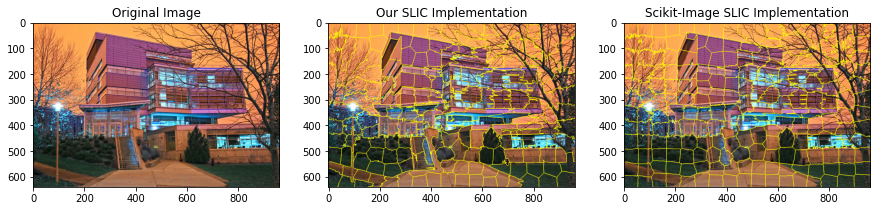

In [50]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2lab
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('Brandeis.jpg')

# Apply SLIC using our implementation
slic_img = slic(img, n_segments=200, compactness=30, max_iter=10, enforce_connectivity=True)


# Apply SLIC using scikit-image's implementation
lab_img = rgb2lab(img)
slic_img_scikit = slic(lab_img, n_segments=200, compactness=30, max_iter=10, enforce_connectivity=True)

# Visualize the results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(mark_boundaries(img, slic_img))
ax[1].set_title('Our SLIC Implementation')
ax[2].imshow(mark_boundaries(img, slic_img_scikit))
ax[2].set_title('Scikit-Image SLIC Implementation')
plt.show()




# 新段落